In [1]:
import os, sys
from typing import *
import cv2
from PIL import Image
from rich.progress import track
import numpy as np
import argparse
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.optim import Adam
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor
import albumentations as A
from torch import nn 

In [2]:
__file__ = "/home/duong/git/ibla/dataset/source"
_root = "/".join(__file__.split("/")[:-1]) + "/source/bagls"
print(os.listdir(_root))

['training.zip', '.ipynb_checkpoints', 'test', 'test.zip', 'training']


In [3]:
class CustomBagls(Dataset):
    def __init__(self, root:str = _root, split='train', args:argparse = None):
        self.root = root
        # self.args = args
        # if self.args is None:
        #     raise ValueError("args cannot be None")
        self._split = split
        self.__mode = "train" if self._split == 'train' else 'test'
        
        self.resize = A.Compose(
            [
                A.Resize(256, 256),
            ]
        )

        self.aug_transforms = A.Compose(
            [
                A.HorizontalFlip(p=0.2),
                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=3, p=0.5, border_mode = cv2.BORDER_CONSTANT),
            ]
        )

        self.norm = A.Compose(
            [
                A.ToFloat(max_value=255, always_apply=False, p=1.0)
            ]
        )
              
        from glob import glob
        self._images = sorted(glob(self.root+ "/*/images/*"), key=lambda x: int(''.join(filter(str.isdigit, x))))
        self._masks = sorted(glob(self.root+ "/*/masks/*"), key=lambda x: int(''.join(filter(str.isdigit, x))))
        
        print("Data Set Setting Up. Done")

    def __len__(self):
        return len(self._images)
    def __getitem__(self, idx):
        image = np.array(Image.open(self._images[idx]).convert("RGB"))
        mask = np.array(Image.open(self._masks[idx]))

        # print("Original Image Size:", image.shape)
        # print("Original Mask Size:", mask.shape)
    
        resized = self.resize(image = image, mask = mask)
        
        # print("Resized Image Size:", resized['image'].shape)
        # print("Resized Mask Size:", resized['mask'].shape)
        
        if self.__mode == 'train':
            transformed = self.aug_transforms(image = resized['image'], mask = resized['mask'])
            transformed_img = self.norm(image=transformed["image"])["image"]
            transformed_mask = transformed["mask"]
        else:
            transformed_img = self.norm(image=transformed['image'])['image']
            transformed_mask = transformed['mask']

        torch_img = torch.from_numpy(transformed_img).permute(-1, 0, 1).float()
        torch_mask = torch.from_numpy(transformed_mask).unsqueeze(-1).permute(-1, 0, 1).float()

        return torch_img, torch_mask

    @property
    def mode(self):
        return self.__mode

    @mode.setter
    def mode(self, m):
        if m not in ['train', 'test']:
            raise ValueError(f"mode cannot be {m} and must be ['train', 'test']")
        else:
            self.__mode = m

In [4]:
train_ds = CustomBagls()
print(len(train_ds))

Data Set Setting Up. Done
59250


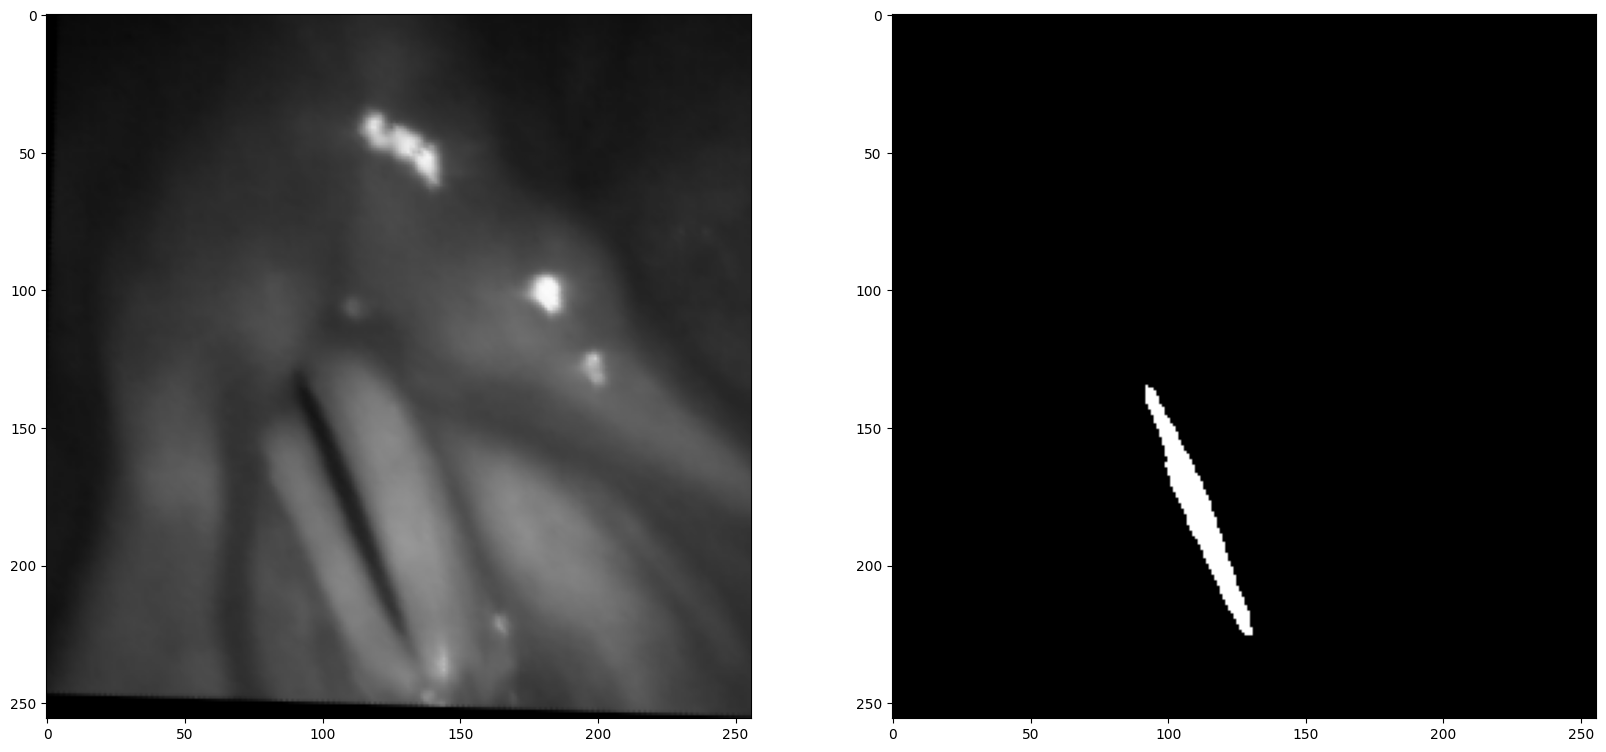

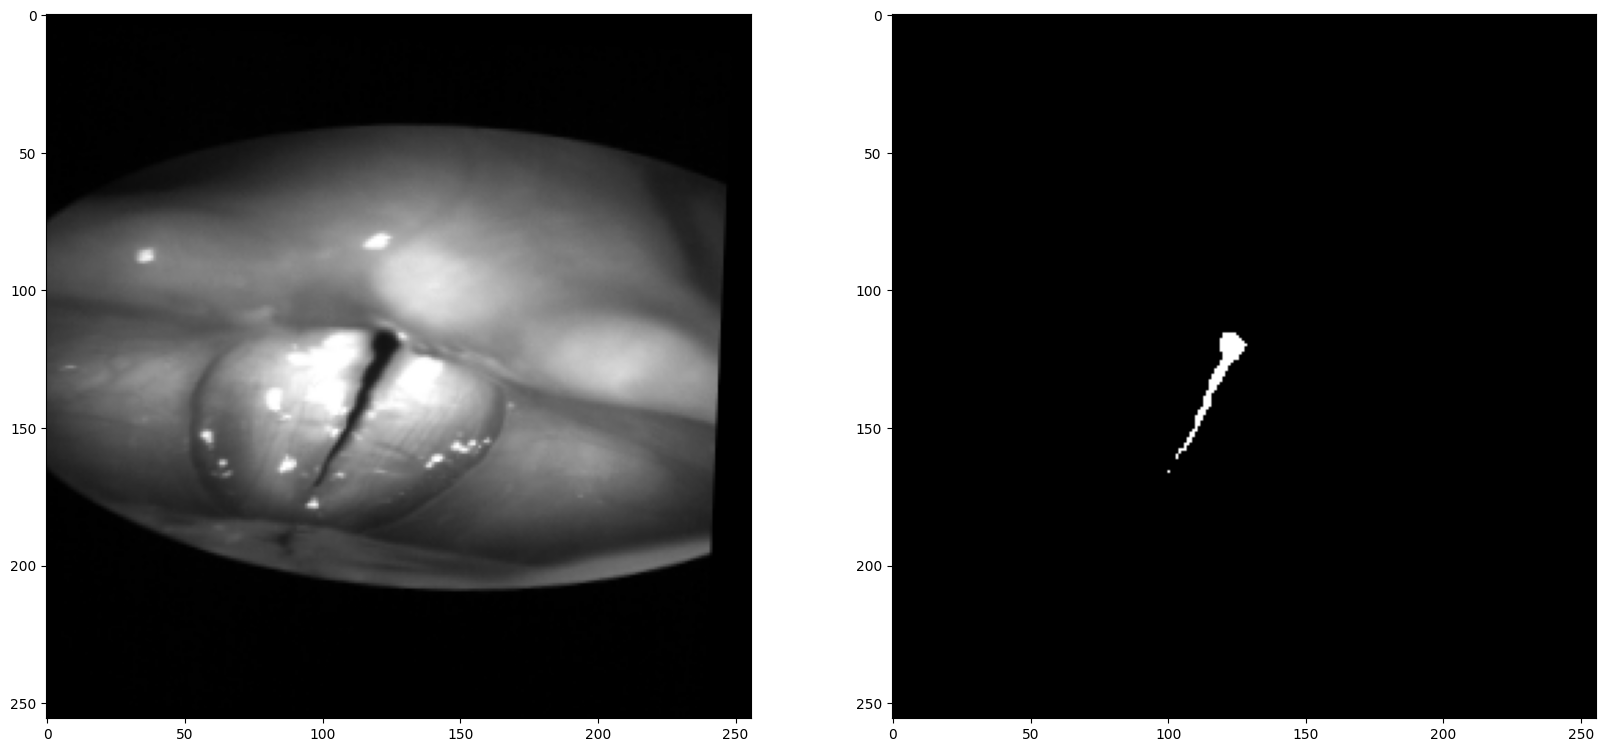

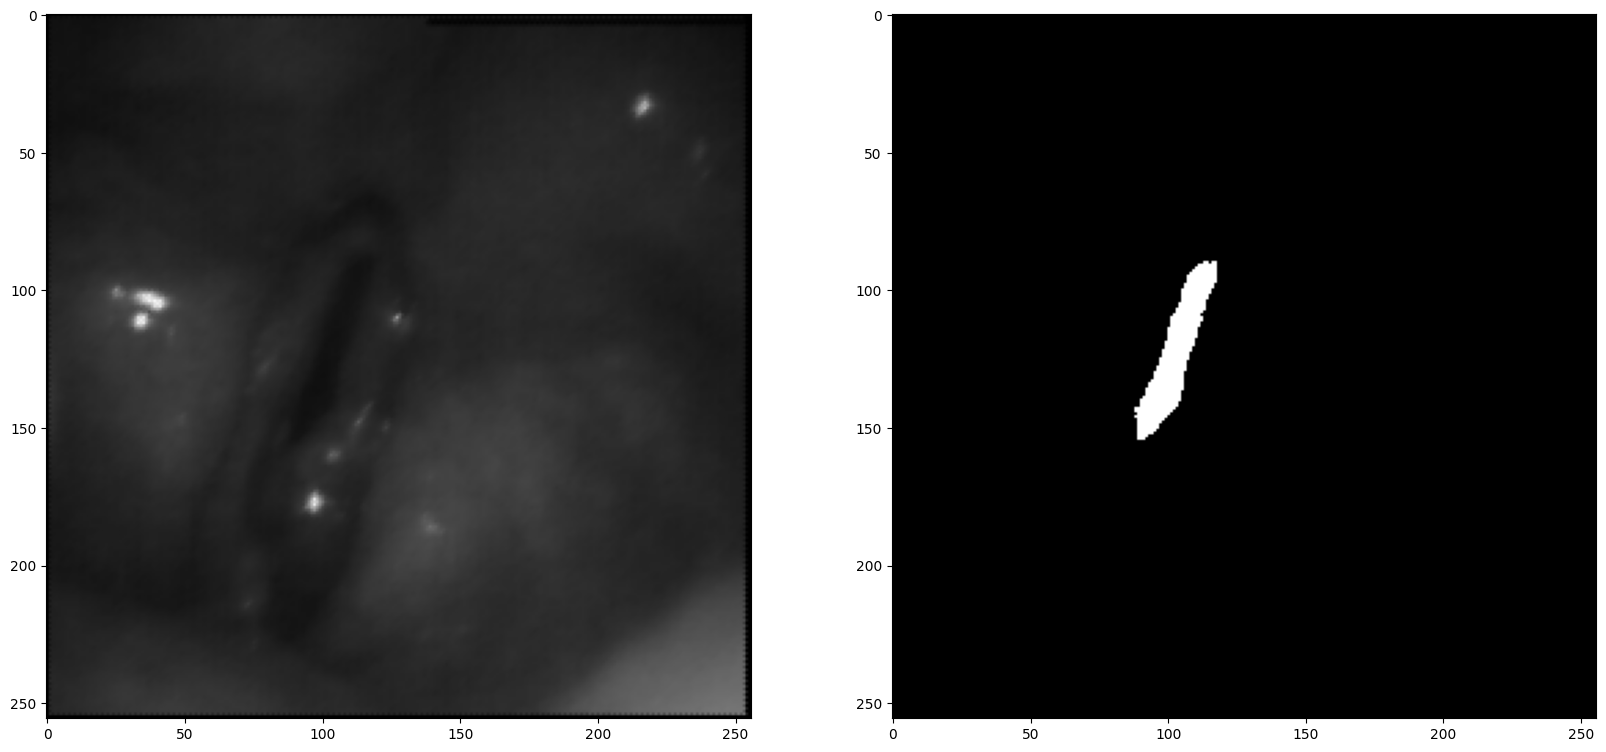

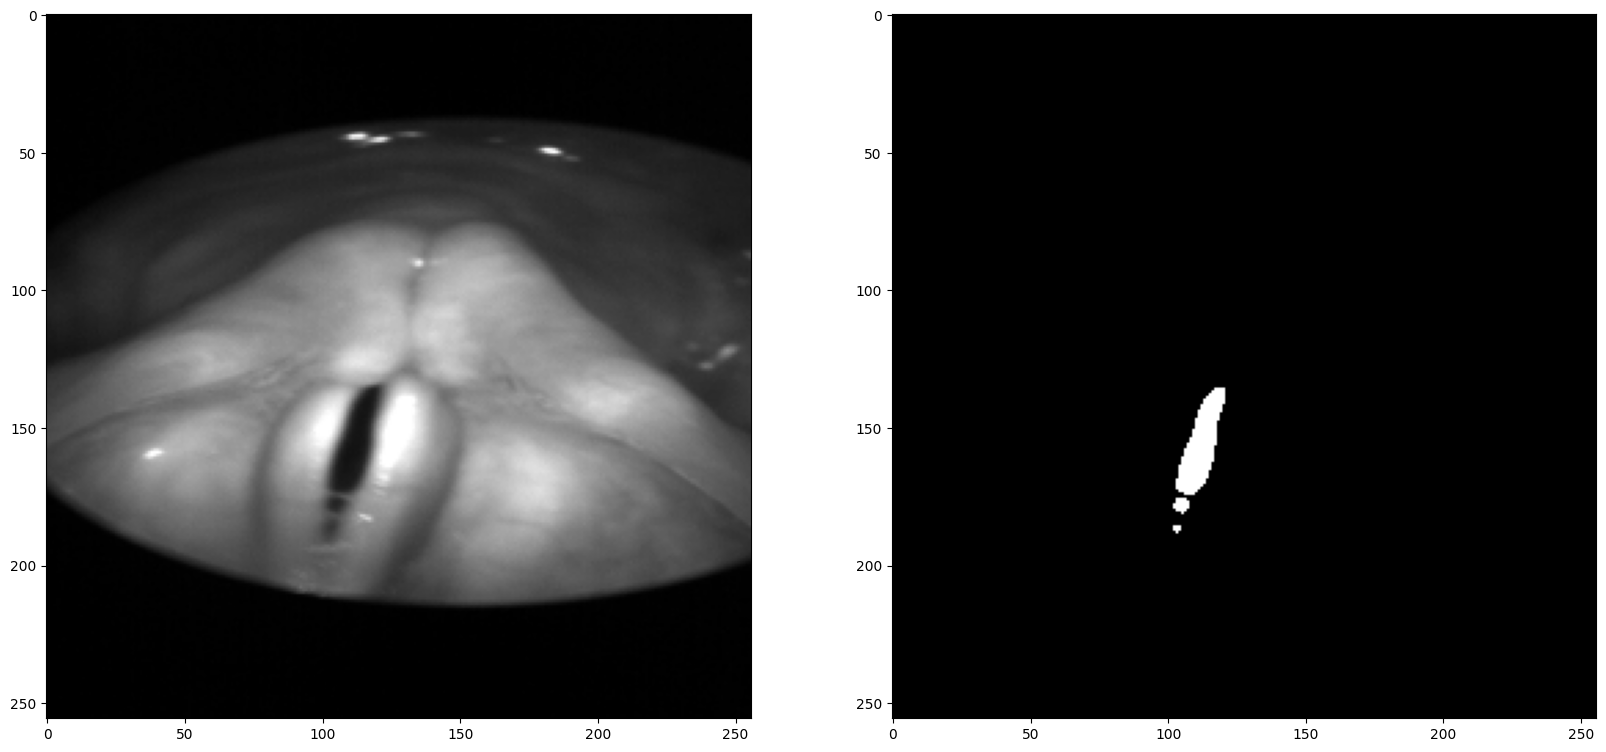

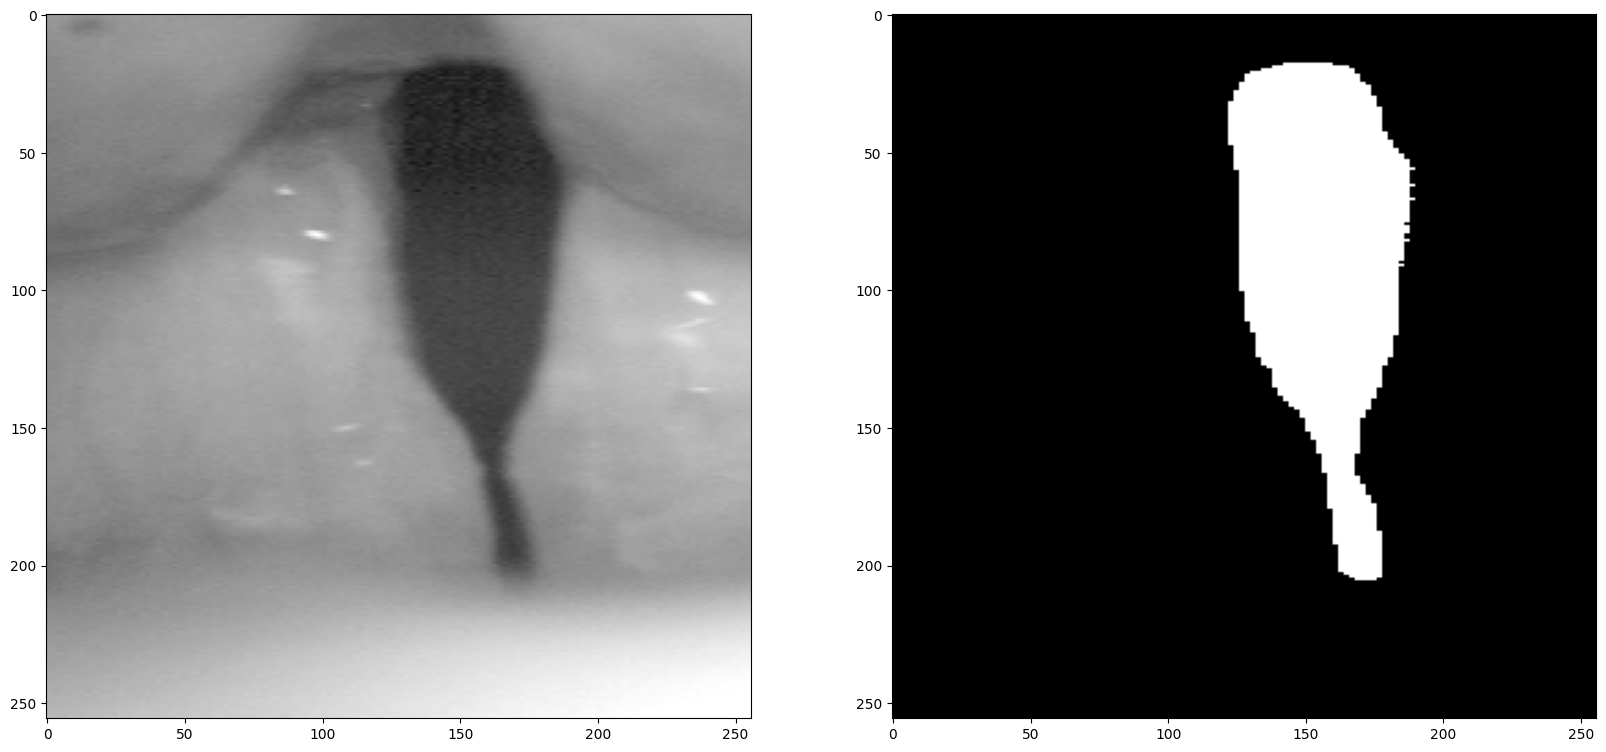

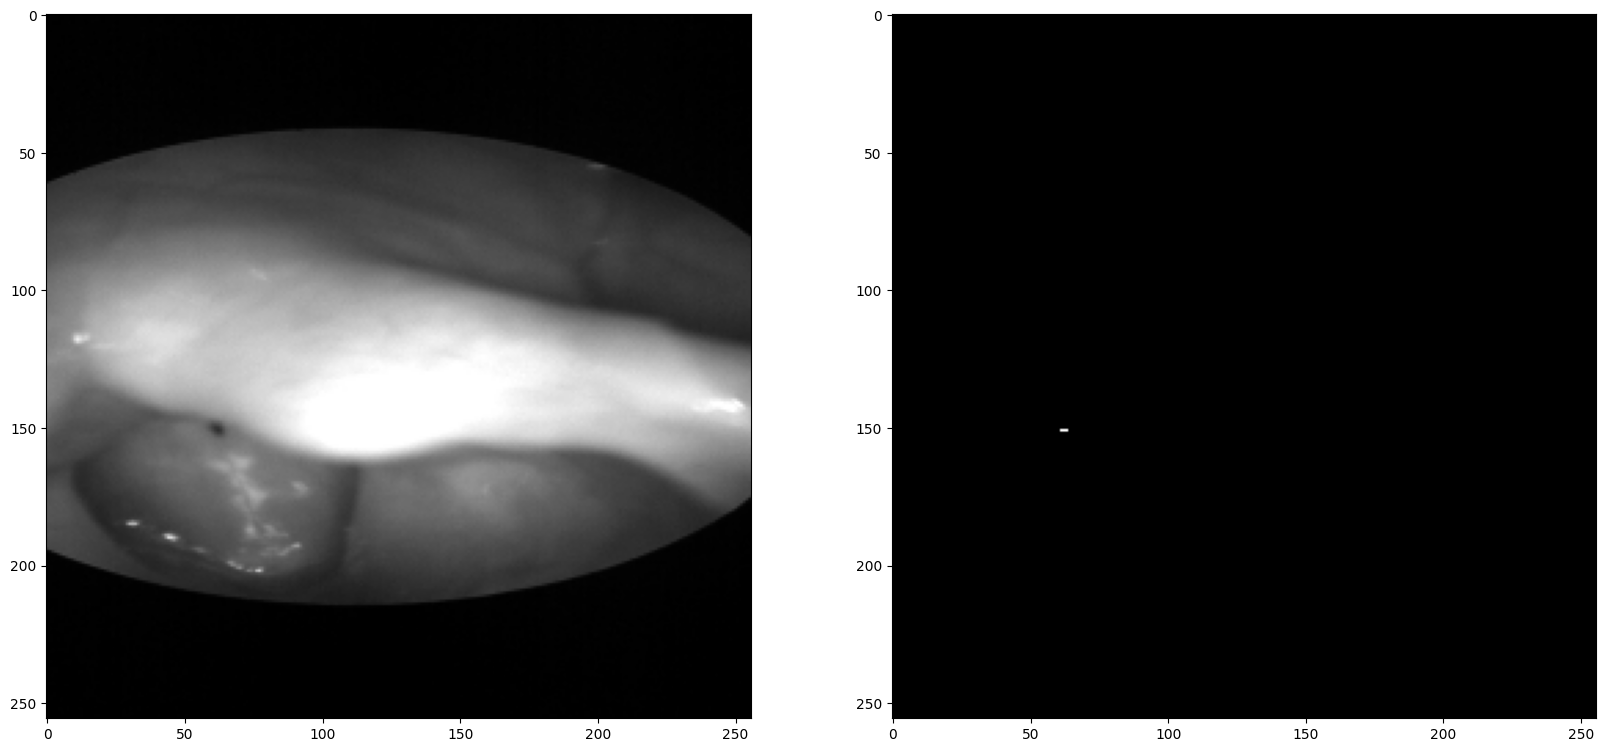

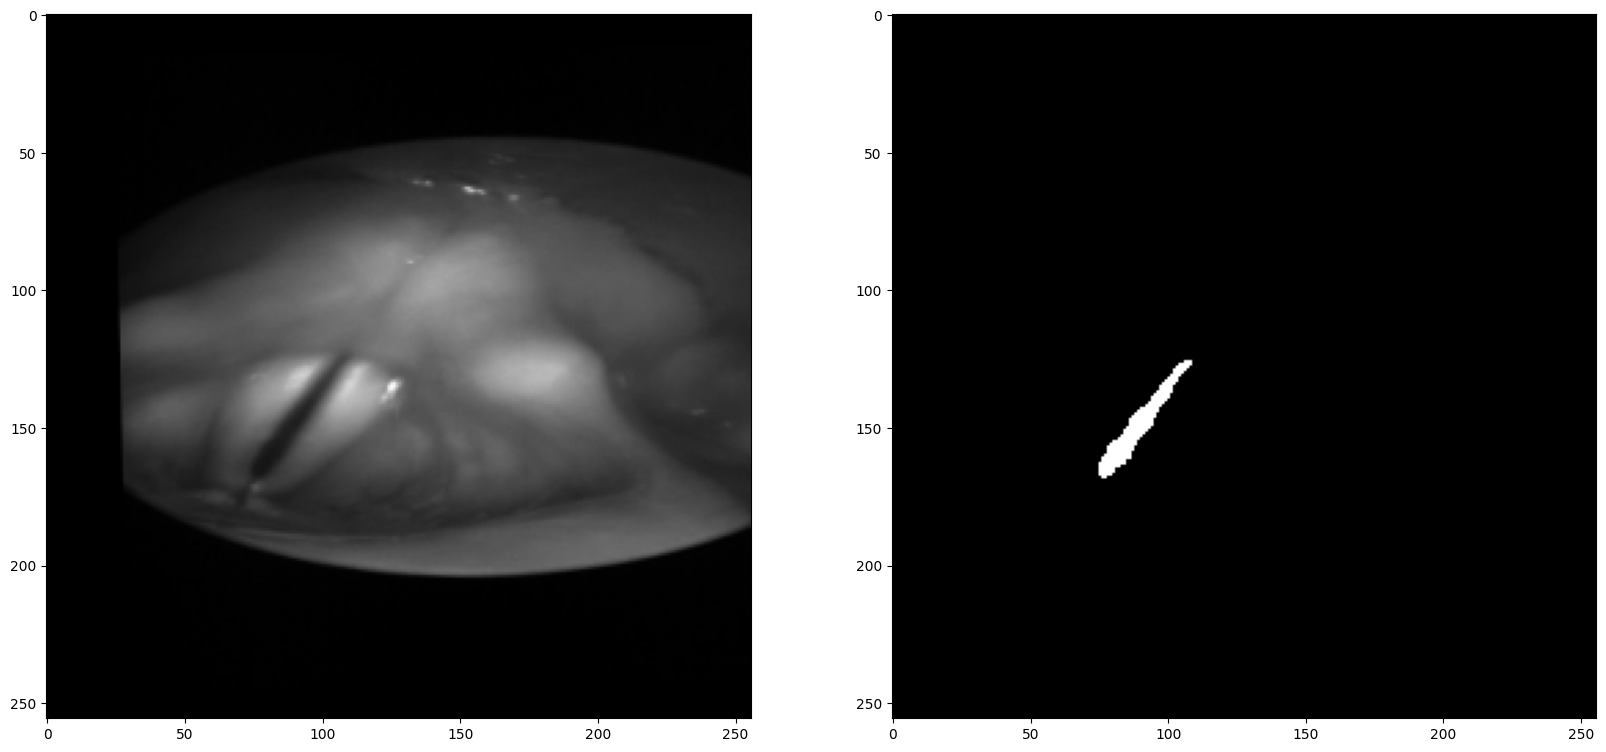

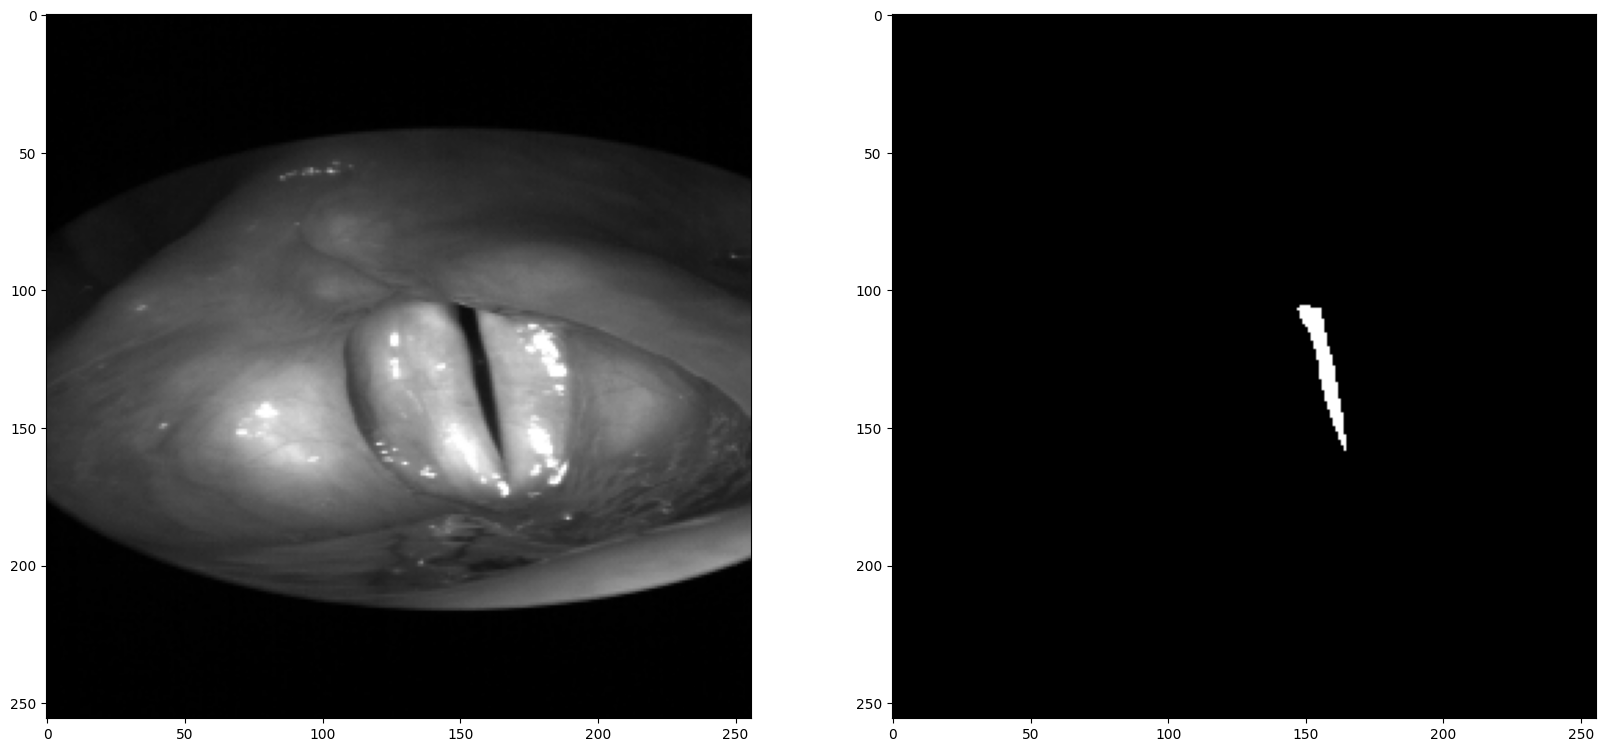

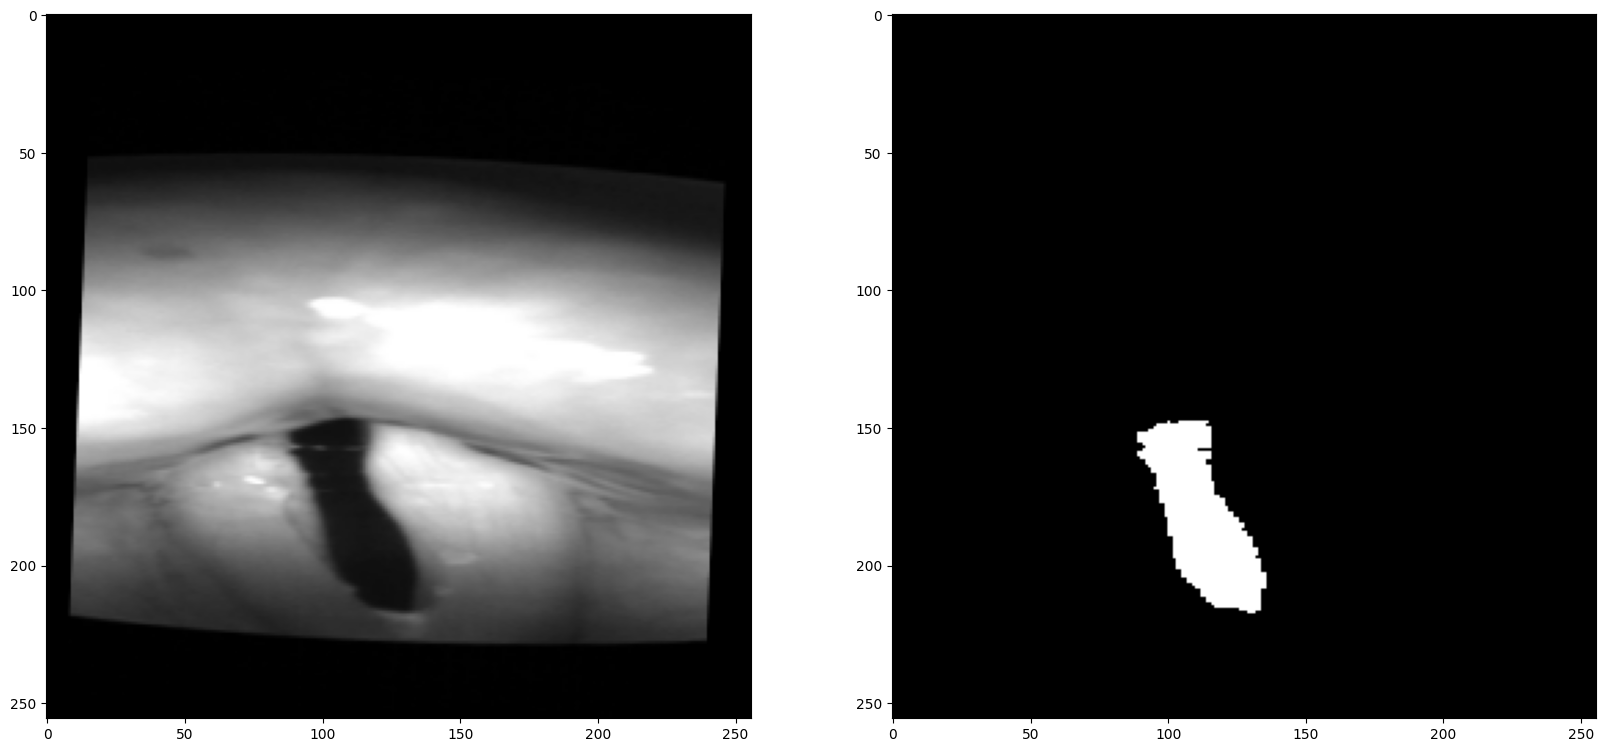

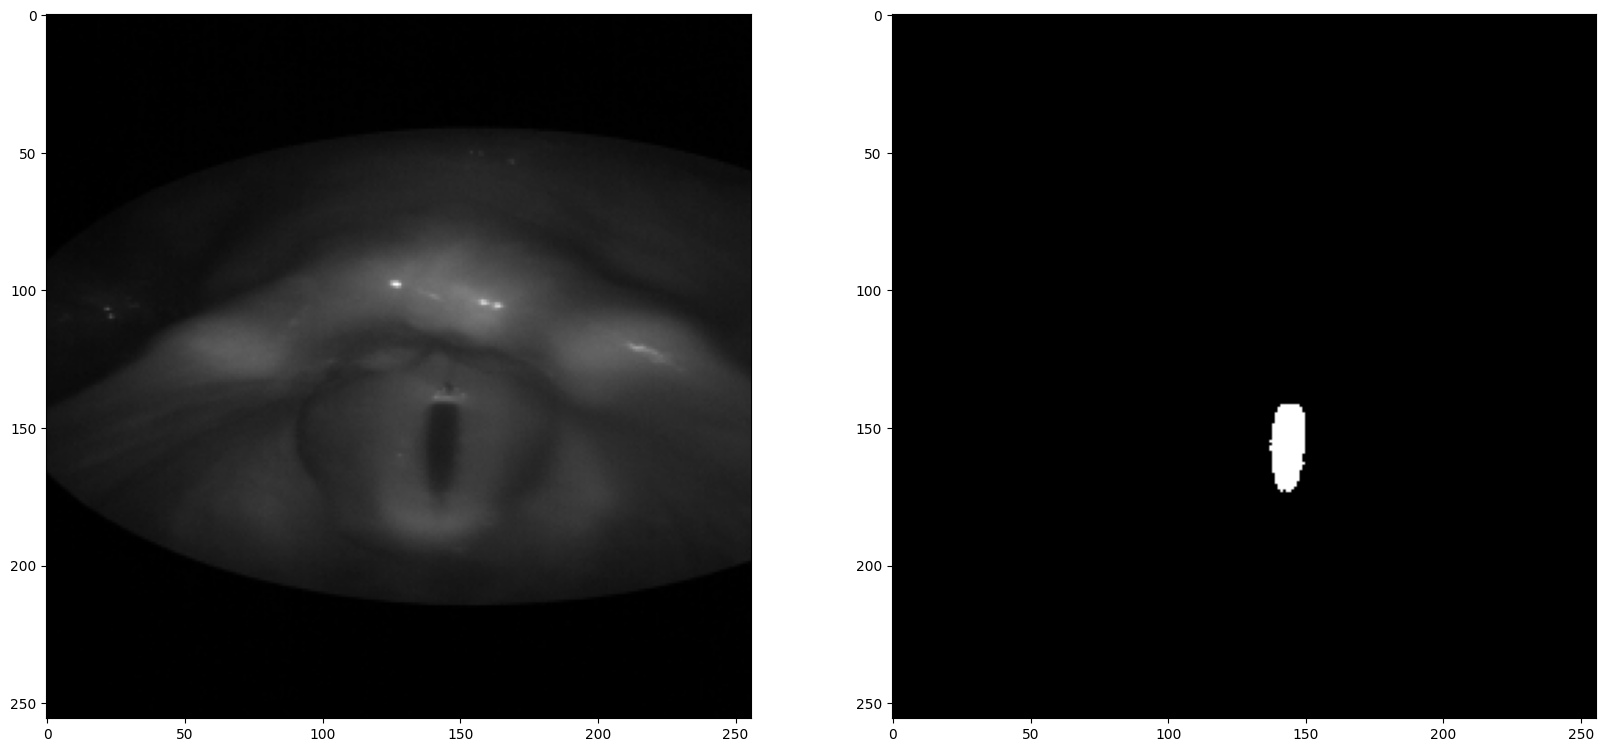

In [5]:
for idx in range (0, 10):
    img, msk = train_ds[idx]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

    ax1.imshow(img.permute(1, -1, 0).numpy())
    # Display only the first channel of the mask
    ax2.imshow(msk.permute(1, -1, 0).numpy(), cmap="gray")

    plt.show()
    plt.close()

In [6]:
print("Unique Values in Mask:", torch.unique(msk))

Unique Values in Mask: tensor([  0., 255.])


In [7]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)

print(len(train_dl))

463


In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [9]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [10]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [11]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [12]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 16))
        self.down1 = (Down(16, 32)) #64, 128
        self.down2 = (Down(32, 64)) #128, 256
        self.down3 = (Down(64, 128)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(128, 256 // factor)) #512, 1024
        self.up1 = (Up(256, 128 // factor, bilinear)) #1024, 512
        self.up2 = (Up(128, 64 // factor, bilinear)) #512, 256
        self.up3 = (Up(64, 32 // factor, bilinear)) #256, 128
        self.up4 = (Up(32, 16, bilinear)) #128, 64
        self.outc = (OutConv(16, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)

model = UNet(3, 1, False).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 20

loss_fn = nn.BCEWithLogitsLoss()

In [14]:
old_loss = 1e26
best_dct = None
last_dct = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    tr_total_dice = 0
    tr_total_iou = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_loss = loss_fn(train_gen_mask, train_mask)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()        
        
        tr_total_loss += train_loss.cpu().item()        
            
    mean_train_loss = tr_total_loss/len(train_dl)

    if mean_train_loss <= old_loss:
        old_loss = mean_train_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss}")
model.load_state_dict(best_dct)

100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:50<00:00,  1.59it/s]


Epoch: 0 - TrainLoss: -70.5179960043783


100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:49<00:00,  1.60it/s]


Epoch: 1 - TrainLoss: -266.8339796292859


100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:49<00:00,  1.60it/s]


Epoch: 2 - TrainLoss: -592.2318353838333


100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:49<00:00,  1.60it/s]


Epoch: 3 - TrainLoss: -1042.9503914686825


100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:49<00:00,  1.60it/s]


Epoch: 4 - TrainLoss: -1601.436010900378


100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:49<00:00,  1.60it/s]


Epoch: 5 - TrainLoss: -2249.4995681400173


100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:50<00:00,  1.60it/s]


Epoch: 6 - TrainLoss: -3015.2262777571545


100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:50<00:00,  1.60it/s]


Epoch: 7 - TrainLoss: -3816.350008014984


100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:49<00:00,  1.60it/s]


Epoch: 8 - TrainLoss: -4763.014034131175


100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:49<00:00,  1.60it/s]


Epoch: 9 - TrainLoss: -5741.666778103065


100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:49<00:00,  1.60it/s]


Epoch: 10 - TrainLoss: -6800.666724318305


100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:50<00:00,  1.60it/s]


Epoch: 11 - TrainLoss: -7922.174833161785


100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:49<00:00,  1.60it/s]


Epoch: 12 - TrainLoss: -9184.021874578159


100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:49<00:00,  1.60it/s]


Epoch: 13 - TrainLoss: -10475.702229641942


100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:49<00:00,  1.60it/s]


Epoch: 14 - TrainLoss: -11771.34744743858


100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:49<00:00,  1.60it/s]


Epoch: 15 - TrainLoss: -13241.78560762014


100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:49<00:00,  1.60it/s]


Epoch: 16 - TrainLoss: -14729.956702213824


100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:47<00:00,  1.61it/s]


Epoch: 17 - TrainLoss: -16194.397395552105


100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:47<00:00,  1.61it/s]


Epoch: 18 - TrainLoss: -17925.961047178727


100%|█████████████████████████████████████████████████████████████████████████████████| 463/463 [04:47<00:00,  1.61it/s]

Epoch: 19 - TrainLoss: -19641.32812078159


<All keys matched successfully>

In [17]:
test_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
print(len(test_dl))

463


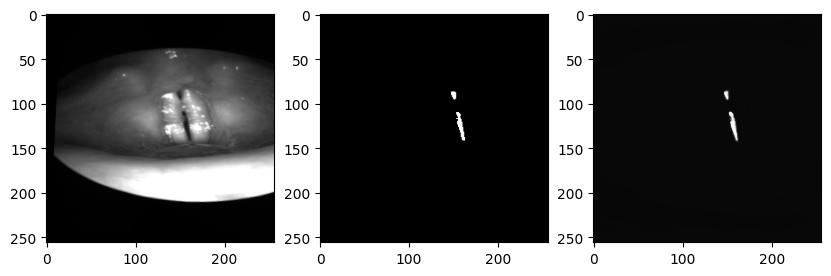

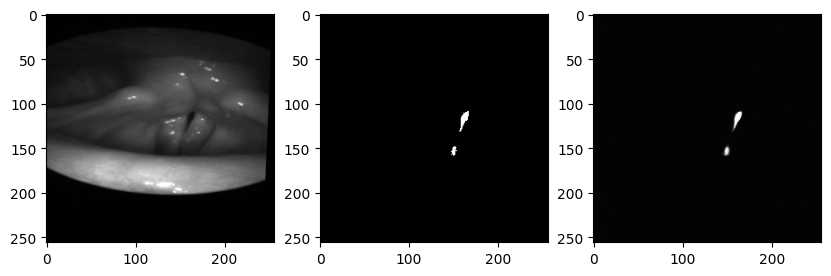

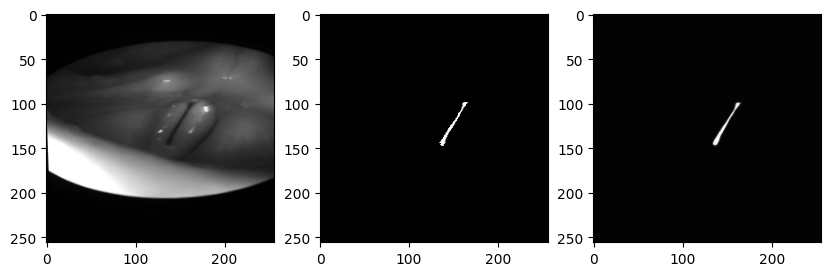

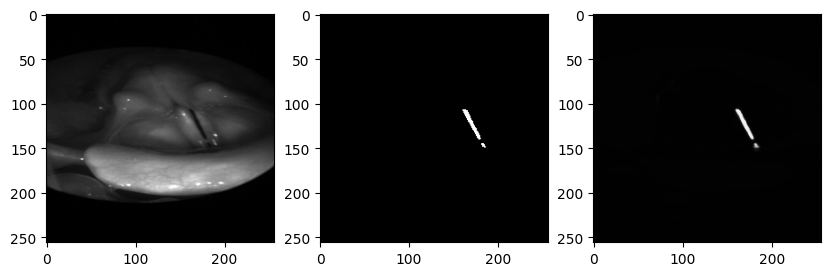

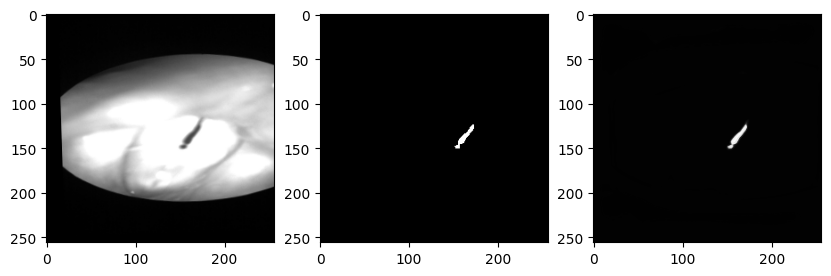

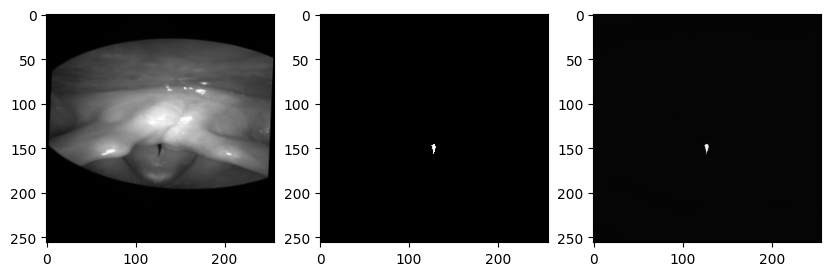

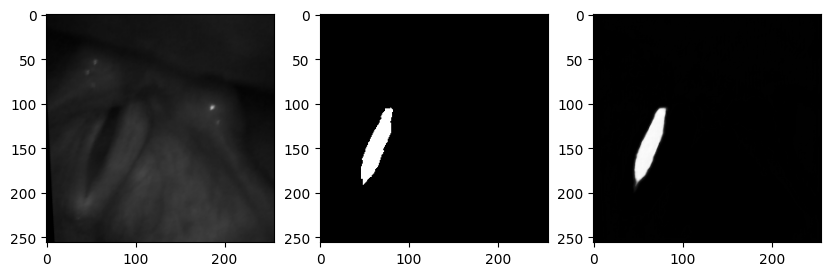

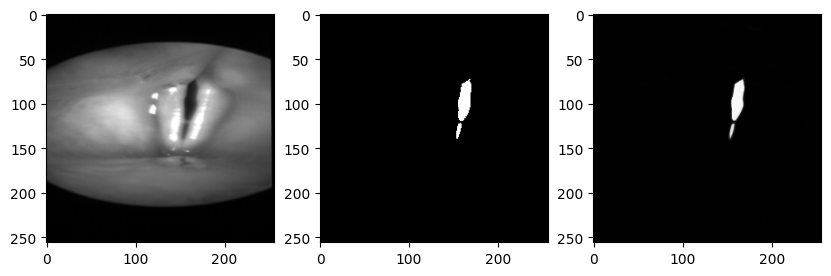

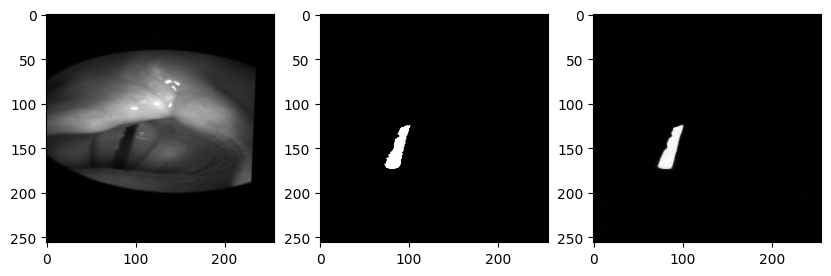

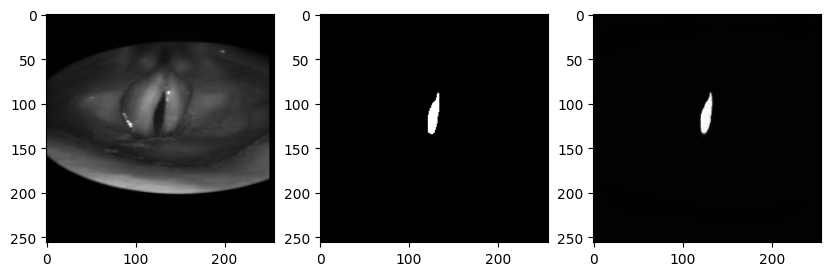

In [26]:
from glob import glob
counter = 0
model = model.cpu()
for img, mask in test_dl:
    img = img
    label = mask
    

    predict = model(img)
 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

    ax1.imshow(img[0].permute(1, -1, 0).detach().cpu().numpy())
    ax2.imshow(label[0].permute(1, -1, 0).detach().cpu().numpy(), cmap = 'gray')
    ax3.imshow(predict[0].permute(1, -1, 0).detach().cpu().numpy(), cmap = 'gray')

    plt.show()  
    plt.close("all")  
    
    counter += 1
    if counter >= 10:
        break